### LOWESS (Locally Weighted Scatterplot Smoothing) Regression: Predicting King County, WA, Housing Prices
 - This project will use one exogenous variable sqft_living to explore price prediction using LOWESS. 

In [1]:
#Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
import scipy.stats as stats
from scipy.interpolate import interp1d
from statsmodels.nonparametric.smoothers_lowess import lowess

import plotly.graph_objects as go # for data visualization
import plotly.express as px # for data visualization 

In [2]:
#Import and preview the data
df = pd.read_csv('kc_house_data.csv')
# display(df.info())
# df.head()

In [3]:
df = df[['price', 'sqft_living']]

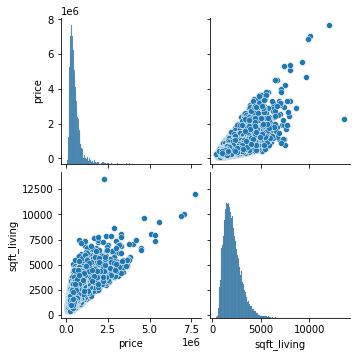

In [4]:
sns.pairplot(df)

In [5]:
#dropping outliers
df.drop(df[df['sqft_living']>8000].index, inplace=True)

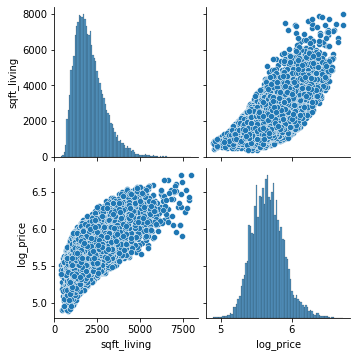

In [6]:
#log transform price to normalize the data. 
df['log_price'] = np.log10(df['price'])
df.drop(columns=['price',], axis=1, inplace=True)
# df['log_sqft_living'] = np.log10(df['sqft_living'])
sns.pairplot(df)

Log transformed price due to both being right skewed data.

### Models

In [8]:
#Create feature and target columns
X = df.drop(columns=['log_price'], axis=1)
y = df.log_price

Training Score: 0.48
Test Score: 0.49
Coefficients: [0.00017557]


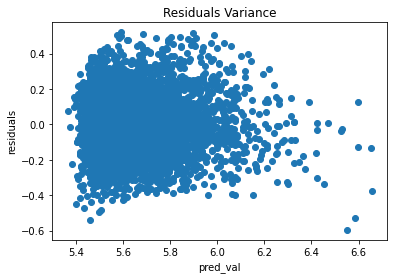

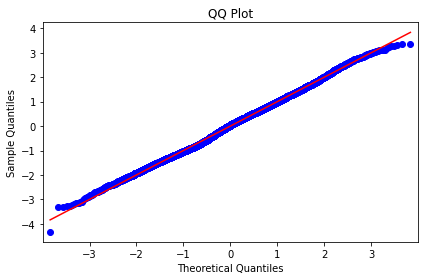

In [9]:

#Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

#Linear
linreg = LinearRegression()
model = linreg.fit(X_train, y_train)


#View model accuracy
train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)

print('Training Score:', round(train_score, 2))
print('Test Score:', round(test_score, 2))
print('Coefficients:', model.coef_)

#Residuals
y_pred = linreg.predict(X_test)
residuals = y_test - y_pred
plt.scatter(y_pred, residuals)
plt.title('Residuals Variance')
plt.ylabel('residuals')
plt.xlabel('pred_val')
plt.show()

X_train_c = sm.add_constant(X_train)
smmodel = sm.OLS(y_train, X_train_c).fit()

fig = sm.graphics.qqplot(smmodel.resid, dist=stats.norm, line='r', fit=True)
plt.title('QQ Plot')
plt.tight_layout()
plt.show()

    
#     return smmodel

The test result for r2 is 0.48. The residuals variance and QQ plots shows a general normal distribution of errors near the mean but with light tailed distrubtion. We will employ the LOWESS function to alter our model for a better fit. 

In [180]:
#convert to vectors
X_v = df.sqft_living.values
y_v = df.log_price.values

#LOWESS
y_hat = lowess(y_v, X_v,frac=1/3)

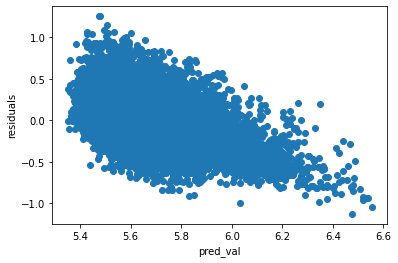

In [181]:
#Residuals
residuals = (y_v - y_hat[:,1],)
plt.scatter(y_hat[:,1], residuals)
plt.ylabel('residuals')
plt.xlabel('pred_val')
plt.show()

In [182]:
y_lin = model.predict(X_v.reshape(-1,1))

In [201]:
#scatterplot
fig = px.scatter(df, x=df.sqft_living, y=df.log_price, 
                 opacity=0.8, color_discrete_sequence=['blue'])


# fit line
fig.add_traces(go.Scatter(x=X_v, y=y_lin, name='Linear Regression', line=dict(color='limegreen')))
fig.add_traces(go.Scatter(x=y_hat[:,0], y=y_hat[:,1], name='LOWESS 1/3', line=dict(color='red')))

fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey', 
                 zeroline=True, zerolinewidth=1, zerolinecolor='lightgrey', 
                 showline=True, linewidth=1, linecolor='black')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey', 
                 zeroline=True, zerolinewidth=1, zerolinecolor='lightgrey', 
                 showline=True, linewidth=1, linecolor='black')
fig.update_layout(title=dict(text="log price based on sqft living space",
                             font=dict(color='black')))
fig.update_layout(dict(plot_bgcolor = 'white'))
fig.update_traces(marker=dict(size=3))

fig.show()

It is clear that predictive value of log price between 5.4 and 6 is strongest with consistant residuals around zero. The LOWESS function did not improve the results for the tails as the variance became even more inconsistent. This is due to the right skewedness of the sqft_living distrubtion. The nature of lowess does not provide any coefficients as a linear function would. 

For the final part, lets predict the price values between the two functional outputs. 

In [193]:
#The square footage that are of interest to me. I would like to see the prices based on my quote. 
my_sqft = [700,750,800,850,900,950,1000,1100,1200,1300,1400,1500,1750,2000]
my_sqft = np.asarray(my_sqft).reshape(-1,1)

# log_mysqft = np.log10(my_sqft).reshape(-1,1)


In [194]:
#interpolation method for lowess prediction
low_nearest = interp1d(x=y_hat[:,0], y=y_hat[:,1], bounds_error=False, kind='nearest', fill_value='extrapolate') 

In [195]:
#Prediction and reconvert from log price back to price
lin_price = model.predict(my_sqft)
lin_price = np.power(lin_price,10).round()
low_price = low_nearest(my_sqft)
low_price = np.power(low_price,10).round()

In [196]:
lin_price.reshape(-1,2)

array([[22006413., 22365231.],
       [22729307., 23098708.],
       [23473503., 23853762.],
       [24239557., 25028038.],
       [25839528., 26674622.],
       [27533928., 28418068.],
       [30741274., 33234037.]])

In [197]:
low_price.reshape(-1,2)

array([[21774578., 22178653.],
       [22588800., 23005597.],
       [23429769., 23861694.],
       [24299339., 25172882.],
       [26039877., 26937959.],
       [27857636., 28749034.],
       [30600506., 32799740.]])